In [1]:
import numpy as np
import torch
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np 
import math 
from skimage.io import imread, imshow
import os

In [2]:
%%time
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu
Wall time: 4 ms


**Carga de datos local**

In [3]:
path_Covid = r'C:\Users\ASUS\Desktop\UTEC\Redes Neuronales (CNN)\Clasificador\COVID' 
path_Normal = r'C:\Users\ASUS\Desktop\UTEC\Redes Neuronales (CNN)\Clasificador\Normal'

In [5]:
#### Funcion para leer imagenes dentro de una carpeta
width = 299
height = 299
def imageReading (path):
    folderFilesids = os.listdir(path)
    images = np.zeros((len(folderFilesids), height, width))
    for count, n in enumerate(folderFilesids):
        path1 = path + '\\' + n
        originalImage = imread(path1)[:,:]    
        images[count] = originalImage
    imshow(images[0])
    plt.show()
    return images

C:\Users\ASUS\anaconda3\envs\pytorch\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


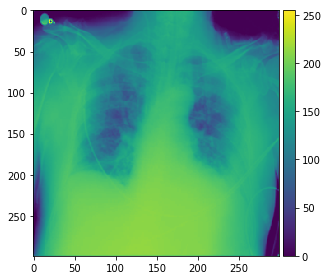

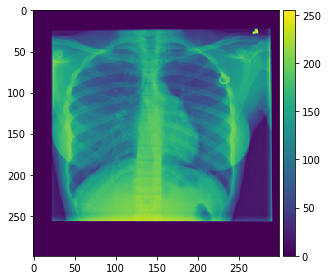

Wall time: 1.15 s


In [6]:
%%time
covid = imageReading(path_Covid)
normal = imageReading(path_Normal)

In [7]:
covid.shape

(99, 299, 299)

In [8]:
normal.shape

(99, 299, 299)

**Agregando dimensiones para que sea leido por pytorch**

In [9]:
covid = torch.from_numpy(np.array(covid).reshape(-1,1,299,299)) ## torch se convierte nuestra data en tensor - Aumenta la dimension.
normal = torch.from_numpy(np.array(normal).reshape(-1,1,299,299)) # (-1: Cantidad de imagenes, 1: gris o color, 299 x 299: tamaño de la imagen

In [10]:
covid.shape

torch.Size([99, 1, 299, 299])

In [11]:
covid[0]

tensor([[[185.,  40.,   0.,  ...,   0.,  24., 131.],
         [ 75.,  14.,   0.,  ...,   0.,   8.,  42.],
         [ 11.,   2.,   0.,  ...,   1.,   3.,  12.],
         ...,
         [ 78.,  62.,  68.,  ...,   3.,  13.,  27.],
         [104.,  74.,  75.,  ...,   1.,  23.,  83.],
         [156.,  90.,  78.,  ...,   1.,  45., 167.]]], dtype=torch.float64)

### Agregamos las etiquetas y transformamos a tuple

In [12]:
img_covidlist = []
for i in range(covid.shape[0]):
      img_covidlist.append((covid[i]/255.0,0.0))

img_normallist = []
for i in range(normal.shape[0]):
      img_normallist.append((normal[i]/255.0,1.0))

In [13]:
img_normallist[0]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]], dtype=torch.float64),
 1.0)

### Verificar el Slicing y tamaño de las listas

In [14]:
len(img_covidlist)

99

In [15]:
len(img_covidlist[int(len(img_covidlist)*0.7):])

30

In [16]:
len(img_covidlist[0:int(len(img_covidlist)*0.7)])

69

In [17]:
len(img_normallist)

99

In [18]:
import random
random.shuffle(img_covidlist)
covid_train = img_covidlist[0:int(len(img_covidlist)*0.7)]
covid_test = img_covidlist[int(len(img_covidlist)*0.7):]

random.shuffle(img_normallist)
normal_train = img_normallist[0:int(len(img_normallist)*0.7)]
normal_test = img_normallist[int(len(img_normallist)*0.7):]

### COVID 

In [19]:
print("El tamaño del training es {} y del test es {}".format(len(covid_train), len(covid_test)))

El tamaño del training es 69 y del test es 30


### NORMAL

In [20]:
print("El tamaño del training es {} y del test es {}".format(len(normal_train), len(normal_test)))

El tamaño del training es 69 y del test es 30


### Unir Train de Covid y Normal y Test de Covid y Normal 

In [21]:
train_beta = covid_train + normal_train
test_beta = covid_test + normal_test

In [22]:
batch_size = 16
train_loader = torch.utils.data.DataLoader(dataset=train_beta, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_beta, batch_size=batch_size, shuffle=True)

## CNN

**Para la construccion de la red convolucional tener en cuenta:**
**Conv2d:** Se usa por que estamos trabajando con imagenes en 2 dimensiones
**in_channel:** Es la cantidad de canales, en caso sea una imagen en gris es 1, si es RGB es 3. Luego puede ir variando a medida que incrementamos el numero de capas.
**out_channels:** Es la cantidad de dimensiones de salida, es decir entra una imagen en escala de grises y salen 16 imagenes adicionales.
**Kernel_size:** El tamaño del kernel que se aplicara, siempre es una matriz cuadrada. Para nuestro caso 4x4
**Stride:** Espacio para el recorrido entre kernel y kernel.
**Pading:** Es una especio de relleno que se le aplica, este relleno puede darse en la parte superior o inferior.

**Nota:** Es importante conocer estos conceptos para saber la salida que se le entregara, se debe aplicar la siguiente formula:  


$\text{Tamaño de salida } = \frac{\text{Tamaño de la imagen } - \text{ Tamaño de kernel } + 2*\text{ Pading }}{Stride}$

In [23]:
#hyperparameter 
num_classes = 2
learning_rate =  0.001
num_epochs = 20

class CNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CNN, self).__init__()
        #input 299x299
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=4, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2,padding=0)) #150 x 150
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=0),  #146
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))  #73x73
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=0),  #36
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.fc = nn.Linear(18*18*64, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        #print('aviso1')
        out = self.layer2(out)
        #print('aviso2')
        out = self.layer3(out)
        #print('aviso3')
        out = out.reshape(out.size(0), -1)
        #print('aviso4')
        out = self.fc(out)
        return out 

In [24]:
model         = CNN(num_classes).to(device)
loss_fn       = nn.CrossEntropyLoss()
optimizer     = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [25]:
def train(model, optimizer, loos_fn, num_epochs):
    loss_vals = []
    running_loss =0.0
    # train the model
    total_step = len(train_loader)  # el train loader es el motor que se encarga de sacar las imagenes del train_set

    list_loss= []
    list_time = []
    j=0

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = images.float().to(device)
            labels = labels.long().to(device)
            # forward 
            output = model(images).float()
            loss   = loss_fn(output, labels)
            # change the params
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            list_loss.append(loss.item())
            list_time.append(j)
            j+=1

            if (i+1) % 100 == 0:
                  print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                        .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    print('Finished Training Trainset')
    return list_loss

In [27]:
%%time
error_train = train(model,optimizer,loss_fn, num_epochs=20)

Finished Training Trainset
Wall time: 1min 4s


## Accuracy en el Test 

In [32]:
with torch.no_grad():
    y_true = []
    y_pred = []  
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.float().to(device), labels.float().to(device)           
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        y_true.append(labels.cpu().data.numpy()) 
        y_pred.append(predicted.cpu().data.numpy())  
        correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the {} test images: {} %'.format(len(test_beta), 100 * correct / total))

Test Accuracy of the model on the 60 test images: 75.0 %


In [33]:
from sklearn.metrics import confusion_matrix
import itertools

confusion_matrix(list(itertools.chain(*y_true)), list(itertools.chain(*y_pred)))

array([[22,  8],
       [ 7, 23]], dtype=int64)

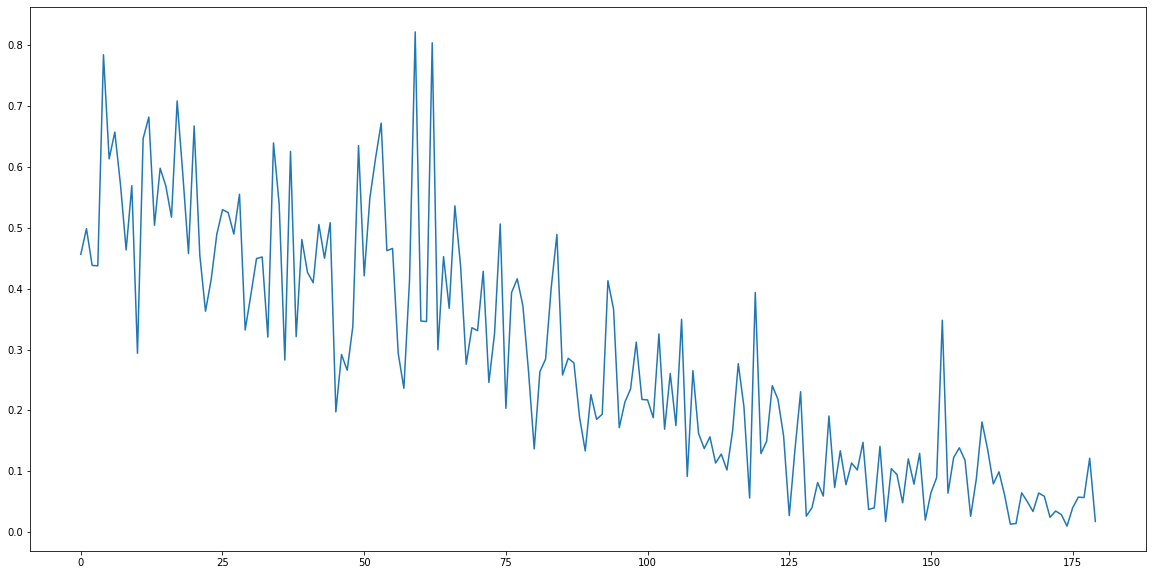

Wall time: 120 ms


In [34]:
%%time
import matplotlib.pyplot as plt
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)
plt.plot(error_train)
plt.show()